In [26]:
import pandas as pd
house_data=pd.read_csv("processed_house_data.csv")
house_data

,Property ID,Size,Bedrooms,Bathrooms,Price,Location_CityB,Location_CityC,Location_CityD,Condition_Good,Condition_New,Condition_Poor,Type_Single Family,Type_Townhouse,House Age
0,SI_000001,3974.0,2.0,2.0,324000.0,0,0,0,1,0,0,1,0,13.916667
1,SI_000002,1660.0,2.0,3.0,795000.0,0,0,0,1,0,0,1,0,88.833333
2,SI_000003,2094.0,2.0,2.0,385000.0,0,1,0,1,0,0,1,0,70.916667
3,SI_000004,1930.0,2.0,3.0,651000.0,1,0,0,1,0,0,1,0,117.000000
4,SI_000005,1895.0,5.0,2.0,1878000.0,1,0,0,0,1,0,1,0,88.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247167,TO_099996,3808.0,3.0,1.0,213000.0,0,0,1,0,0,0,0,1,2.500000
247168,TO_099997,3404.0,1.0,3.0,170000.0,0,1,0,0,0,0,0,1,60.750000
247169,TO_099998,2279.0,4.0,3.0,675000.0,0,1,0,0,1,0,0,1,17.500000
247170,TO_099999,2022.0,2.0,1.0,403000.0,0,0,0,0,0,0,0,1,69.500000


In [4]:

!nvcc --version
!pip install cupy-cuda11x
import cupy as cp
print(cp.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 MB 8.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


13.4.1


In [24]:
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [9]:
house_data.head()

,Property ID,Size,Bedrooms,Bathrooms,Price,Location_CityB,Location_CityC,Location_CityD,Condition_Good,Condition_New,Condition_Poor,Type_Single Family,Type_Townhouse,House Age
0,SI_000001,3974.0,2.0,2.0,324000.0,0,0,0,1,0,0,1,0,13.916667
1,SI_000002,1660.0,2.0,3.0,795000.0,0,0,0,1,0,0,1,0,88.833333
2,SI_000003,2094.0,2.0,2.0,385000.0,0,1,0,1,0,0,1,0,70.916667
3,SI_000004,1930.0,2.0,3.0,651000.0,1,0,0,1,0,0,1,0,117.000000
4,SI_000005,1895.0,5.0,2.0,1878000.0,1,0,0,0,1,0,1,0,88.833333


In [27]:


# Drop unnecessary columns
house_data = house_data.drop(columns=['Property ID'])

# Separate features and target variable
X = house_data.drop(columns=["Price"])  # Features
y = house_data["Price"]  # Target variable

# Normalize Features (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [28]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict with Linear Regression
y_train_lr = lr_model.predict(X_train)
y_test_lr = lr_model.predict(X_test)

# Compute residuals (errors)
residuals_train = y_train - y_train_lr
residuals_test = y_test - y_test_lr


In [29]:
# Convert to PyTorch tensors and move to GPU
X_train_torch = torch.tensor(X_train, dtype=torch.float32, device="cuda")
X_test_torch = torch.tensor(X_test, dtype=torch.float32, device="cuda")
residuals_train_torch = torch.tensor(residuals_train.values, dtype=torch.float32, device="cuda")


In [30]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.mlls import VariationalELBO

# Select 1000 Inducing Points
num_inducing = 1000
inducing_points = X_train_torch[:num_inducing]

# Define Sparse Gaussian Process Model
class SparseGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(num_inducing)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(SparseGP, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize Model and Likelihood
gpr_model = SparseGP(inducing_points).cuda()
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()

# Define Loss Function (Marginal Log-Likelihood)
mll = VariationalELBO(likelihood, gpr_model, num_data=X_train.shape[0])
optimizer = torch.optim.Adam(gpr_model.parameters(), lr=0.01)


In [31]:
# Set Model to Training Mode
gpr_model.train()
likelihood.train()

# Training Loop
epochs = 50
for i in range(epochs):
    optimizer.zero_grad()
    output = gpr_model(X_train_torch)
    loss = -mll(output, residuals_train_torch)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Epoch {i}/{epochs} - Loss: {loss.item()}")


Epoch 0/50 - Loss: 14983142400.0
Epoch 10/50 - Loss: 14983139328.0
Epoch 20/50 - Loss: 14983135232.0
Epoch 30/50 - Loss: 14983129088.0
Epoch 40/50 - Loss: 14983117824.0


In [32]:
# Set Model to Evaluation Mode
gpr_model.eval()
likelihood.eval()

# Predict Residuals on Test Set
with torch.no_grad():
    residuals_test_pred_torch = likelihood(gpr_model(X_test_torch)).mean

# Convert back to NumPy
residuals_test_pred = residuals_test_pred_torch.cpu().numpy()


In [33]:
# Final Predictions = Linear Regression Predictions + GPR Residual Correction
y_test_final = y_test_lr + residuals_test_pred


In [37]:
# Compute Performance Metrics
test_r2 = r2_score(y_test, y_test_final)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_final,))
test_mae =np.sqrt( mean_absolute_error(y_test, y_test_final))

print("📊 **Hybrid Model (Linear Regression + SGPR on GPU) Performance**")
print(f"➡ Test R²: {test_r2:.4f}")
print(f"➡ Test RMSE: ${test_rmse:,.2f}")
print(f"➡ Test MAE: ${test_mae:,.2f}")


📊 **Hybrid Model (Linear Regression + SGPR on GPU) Performance**
➡ Test R²: 0.4685
➡ Test RMSE: $168,977.68
➡ Test MAE: $352.11


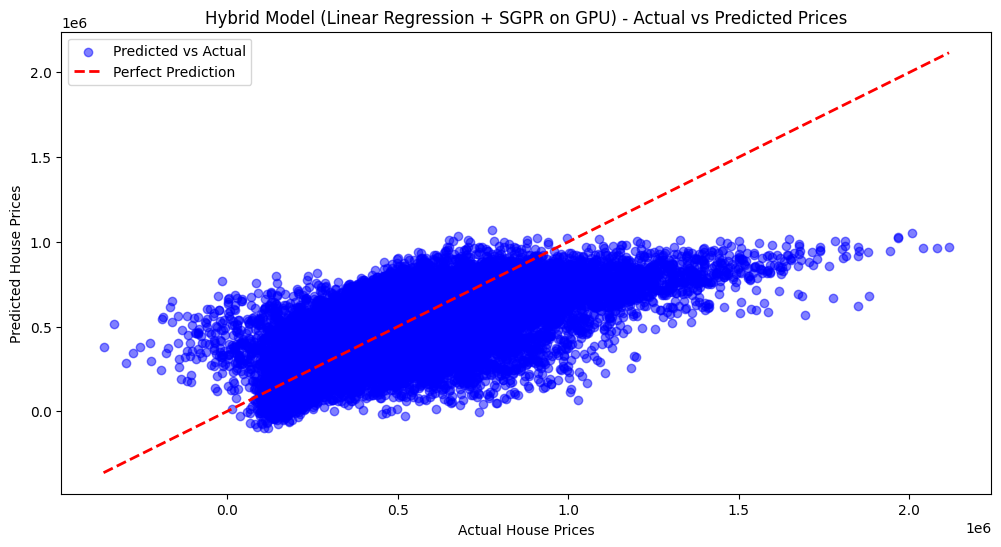

In [38]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_final, alpha=0.5, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Hybrid Model (Linear Regression + SGPR on GPU) - Actual vs Predicted Prices")
plt.legend()
plt.show()
